# Exercise 3 - Structuring Your Deep Learning Project

Many modern digital cameras and camera apps on your phone do face recognition. Usually you see them draw a square around a detected face and make sure it is in focus:

![face detection on sony A6000](http://www.paulvangent.com/files/DL_Course/day2_images/FaceRec.jpg)

How hard could this be? You're all smart engineers so let's figure this out! At the end of this notebook you will know how to build such a system.

In this notebook you'll learn how to set up a default project structure when approaching a new deep learning problem. You will build several 'building blocks' that you can re-use later on. This way, each time you start a new project, you will be on your way faster.

The focus in this notebook is on writing simple and reusable functions.

### Index
- 3.1 - Preprocessing your dataset
- 3.2 - Options for loading your dataset
    - loading into RAM
    - memory mapping large set
    - dynamic loading  with data generator
- 3.3 - Visualising your training data
- 3.4 - Fitting the model
    - Monitoring performance: warning signs
    - Early Stopping
- 3.5 - Testing and visualising results

Let's get started! Run the cell below to import everything required for this notebook.

In [1]:
#download required datasets for this notebook (might take a bit, be patient!)
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if os.path.isfile(file):
        os.remove(file)
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")
        
def unzip(file):
    with ZipFile(file) as f:
        f.extractall()
    print('unzipped file: %s\n' %file)
    
    
try:
    download('http://www.paulvangent.com/files/DL_Course/celeba_larger.zip', 'celeba_larger.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754594&authkey=AIcRTaFQqi0WnIo', 'celeba_larger.zip')
unzip('celeba_larger.zip')

try:
    download('http://www.paulvangent.com/files/DL_Course/misc_day2.zip', 'misc_day2.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754608&authkey=AOJO5mcV9eCZsJ8', 'misc_day2.zip')
unzip('misc_day2.zip')

try:
    download('http://www.paulvangent.com/files/DL_Course/test_images.zip', 'test_images.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754595&authkey=AETVSL8bPBIpTnI', 'test_images.zip')
unzip('test_images.zip')

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import sys
import random

import cv2
from keras.datasets import cifar10
import keras
import pandas as pd

import utils_day2 as utils

Download file... celeba_larger.zip ...
File downloaded
unzipped file: celeba_larger.zip

Download file... misc_day2.zip ...
File downloaded
unzipped file: misc_day2.zip

Download file... test_images.zip ...
File downloaded
unzipped file: test_images.zip



C:\Users\palka\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 3.1 Preprocessing your dataset

The first thing you'll do is build a preprocessing function that encompasses what you learned in exercise two. We will again use the subset of the CelebA dataset and this time include the bounding boxes annotated around the faces:

![bb examples](http://www.paulvangent.com/files/DL_Course/day2_images/bb_examples.jpg)

**Exercise:**

Make a pre-processing function. We made this one a bit more complex to keep you challenged.

- It should take an image and face boundingbox label as arguments
- It should normalize or standardize the input image (your choice, what you think is best)
- Realize that when you scale the image, you also  need to scale the bounding box!
    - the annotation format is: *[x1, y1, width, height]*

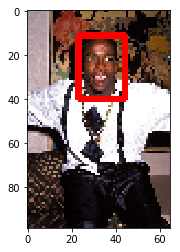

In [2]:
###Start coding segment###
#Complete the code below.

def pre_process(image, label, max_size=100):
    '''
    function takes in image and label
    along with max_size argument.
    
    returns normalized and resizedimage and label
    '''

    resize_factor = max_size / np.max(image.shape)

    resized = cv2.resize(image, (int(image.shape[1] * resize_factor),
                                 int(image.shape[0] * resize_factor)))
    
    label = (label * resize_factor).astype(np.int)
    
    return resized, label

###End of coding segment###

#Let's get a random image and annotation for it
img = cv2.imread('celeba_larger/data/101861.jpg')
annotations = pd.read_csv('celeba_larger/labels/list_bbox_celeba.txt')
bb1 = annotations[1861:1862].values[0][1:]

#Here we call your pre-processing function to resize the image and the label
img, bb1 = pre_process(img, bb1, max_size=100)

#Let's draw your resized boundingbox on the resized image to check
#note that cv2.rectangle wants [x,y] for top left and bottom right corners, not width and height!
img = cv2.rectangle(img, (bb1[0], bb1[1]), (bb1[0]+bb1[2], bb1[1]+bb1[3]), (0,0,255), thickness=2)

#And visualise
plt.imshow(img[...,::-1])
plt.show()

If you find that your bounding box does not match the face, see where you went wrong. Did you mix up dimensions? Did you not scale properly? What else can you have done wrong?

-------------

## 3.2 Loading data

Before feeding training data to the network you need to load it. You basically have three options. We'll explore each briefly, although we'll say now that the data generator (see also exercise 1 of today) is superior both in flexibility and re-usability.

In this section we'll show you how to use all three methods.

You'll work with both the cifar10 dataset, and a subset of the [celebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

### Loading your data into RAM

**Exercise:**

Complete the code below to load the dataset into memory.

- Use data type 'unsigned 8bit integer' (np.uint8)
- cifar10 has 50.000 images of 32x32x3 each (32x32pixels, 3 color channels)

In [3]:
#load images
(X_train, Y_train), _ = cifar10.load_data()

###Start of coding segment###
#Complete the code below (approx. 2 lines)
#define arrays filled with zeros
X = np.zeros(shape=(50000, 32, 32, 3), dtype=np.uint8)
Y = np.zeros(shape=(50000,), dtype=np.uint8)

#Complete the code below (approx. 2 lines)
#put images and labels into the arrays we just created
for i in range(len(X_train)):
    X[i] = X_train[i]
    Y[i] = Y_train[i]
###End of coding segment###

#this section shows the memory footprint of the objects
footprint_X = utils.get_size(X)
footprint_Y = utils.get_size(Y)

print('training object uses: %f MB\nlabel object uses: %f MB' %(footprint_X / 1000000,
                                                                footprint_Y / 1000000))

training object uses: 153.600626 MB
label object uses: 0.050146 MB


Expected output:

------------
training object uses: 153.600626 MB

label object uses: 0.050146 MB

------------


**Advantages of loading data into RAM**

- It allows for fast access times, meaning fetching of training data will not be a bottleneck
- It's very easy to write a 'quick and dirty' solution no matter how the data is structured

**Drawbacks of loading data into RAM**

![more ram?](http://www.paulvangent.com/files/DL_Course/day2_images/moreram.jpg)

- Almost no modern deep learning dataset will fit in RAM.
- Image data will take a lot more space in RAM than the file on the disk, as it will be loaded as an uncompressed array.
- If you exceed the available RAM, your OS will start swapping portions to disk. 
    - *This potentially creates worse slowdowns than when using the other two approaches*

**When to use?**

Ideally never. However for datasets not requiring much space (some types of numerical sensor-data for example) you could choose this option.

--------

### Memory mapped objects

A memory mapped object stores all its data on the hard drive, and maps that to a virtual memory space. This means Python can access all data as if the data were loaded into RAM, except the actual data is stored on disk.

Let's give that a try.

**Exercise:**

Complete the code below to create a memory-mapped object storing the first 10000 images from cifar10. Cifar10 contains images of 32x32x3 pixels (colour images)

[Hint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.memmap.html)

**Note** that in this example, we use cifar10 for simplicity's sake, because the memmap requires a well-defined shape.

In [4]:
#Complete the code below (approx. 2 lines)
#create memmap
X = np.memmap('X.mmap', mode='w+', dtype=np.uint8(),
              shape=(50000, 32, 32, 3))
Y = np.memmap('Y.mmap', mode='w+', dtype=np.uint8(),
              shape=(50000, 1))

#Complete the code below (approx. 2 lines)
#write files to memmap
for i in range(len(X_train)):
    X[i] = X_train[i]
    Y[i] = Y_train[i]
       
#this section shows the memory footprint of the objects
footprint_X = utils.get_size(X)
footprint_Y = utils.get_size(Y)

print('training memmap uses: %f MB\nlabel memmap uses: %f MB' %(footprint_X / 1000000,
                                                                footprint_Y / 1000000))
#you close the memmap by deleting the object
#this allows the OS to write changes to disk, so always close it after use!
del X
del Y

training memmap uses: 0.001810 MB
label memmap uses: 0.001241 MB


Expected output:

-------
training memmap uses: 0.001827 MB

label memmap uses: 0.001258 MB

-------

Even though the same data is being used, the memory mapped object only uses 0.002 MegaBytes, compared to 153 MegaBytes for when loading all images into an array in memory. Note that the memmap file is not magic: it *will* claim 153MB on the harddrive in stead! Hard drives are many times larger than RAM so this is not always a problem.

**Advantages of using a memory mapped object**

- You can work with datasets that don't fit in your RAM, provided you have the disk space.
- It allows for parallel access. 
    - If you have multiple GPUs, this means you can train multiple models simultaneously without needing extra RAM or disk space for the training data.
- memmap files work just like numpy arrays, so you already know how to work with them!
- It's very easy to write a 'quick and dirty' solution no matter how the data is structured

**Drawbacks of using a memory mapped object**

- Data will still need to be read from disk, which is relatively slow
- Especially image data will be much larger than when stored in jpeg format
    - Just like when loading into ram it is stored in uncompressed binary format. The only difference is *where* the data is stored.

**When to use a memory mapped object?**

In situations you will encounter: not often. However when pre-processing can take a lot of time it can become a bottleneck, slowing down model fitting. In this case you might consider pre-processing everything once and storing it in a memmap object for quick access.

-----
For completeness sake, the cell below illustrates how to open a memmap object. **Note that** the shape needs to be known when opening it, as it's just a binary blob of data on the disk!

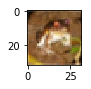

In [5]:
#re-open memmap 
X = np.memmap('X.mmap', mode='r', dtype=np.uint8, shape=(50000, 32, 32, 3))

#plot image
plt.figure(figsize=(1,1))
plt.imshow(X[0])
plt.show()

del X

### Using a Data Generator

In the exercise 1 today you learned to make a data generator. In general we recommend this approach in most situations. You could also combine approaches. For example, if your data requires a lot of pre-processing time, you might consider making a memory mapped object containing the data, or a folder with processed images. You can then use a data generator to load these.

-----

**Exercise:**

Implement a data generator below to train for the CelebA data subset.

- The filelist and labels are pre-loaded for you.
- Ensure the order of the output labels is random
    - **Tip:** you can use a list of indices, shuffle that, and use to recover the corresponding image and label
- It should include at least one augmentation option with a 50% chance of augmenting each image
    - See 2.4 for examples of augmentation.
- Make sure you normalize the image and label!
    
**Be smart about it: re-use the functions you wrote above!**

In [11]:
filelist = glob('celeba_larger/data/*.jpg')
labels = pd.read_csv('celeba_larger/labels/list_bbox_celeba.txt').values[:,1:,]

def dataGen(filelist, labels, batch_size=32, max_size=100):
    
    #sanity check
    assert len(filelist) == len(labels)
    
    ###Start of coding segment###
    #Complete the code below
    
    #generate a list of indices
    indices = [x for x in range(len(filelist))]
    
    #Remember generators need to run infinitely
    while True:
        random.shuffle(indices)
        
        X = np.zeros((batch_size, max_size, max_size, 3), dtype=np.float32)
        Y = np.zeros((batch_size, len(labels[0])))
        
        for i in range(batch_size):
            img = cv2.imread(filelist[indices[i]])
            label = labels[indices[i]]
            
            img, label = pre_process(img, label, max_size=max_size)
            
            if np.random.randint(0,2) == 1:
                noise = np.random.randint(-100, 100, size=(img.shape[0], img.shape[1], 3))
                #generate noise between 0.1 and 0.3
                noise_amount = (0.3 - 0.1) * np.random.random_sample() + 0.1
                #add noise to image
                img = np.clip(img + (noise_amount * noise), a_min=0, a_max=255)
        
            X[i][0:img.shape[0], 0:img.shape[1]] = img / 255.
            Y[i] = label / max_size
        
        #return the batch with yield, ensuring the function keeps running
        #for testing on a single batch, use 'return'
        #return X, Y
        yield X, Y

**Exercise:**

Test the data generator you've just created.

- Have it output a batch of 16 images
- Visualise using plt.imshow as we did earlier

**Hint:** temporarily replacing 'yield' with with 'return' is an easy way to prevent the data generator from running infinitely once you call it. Don't forget to run the cell after you've replaced it, and **don't forget to change it back** once you've finished testing it and it works.

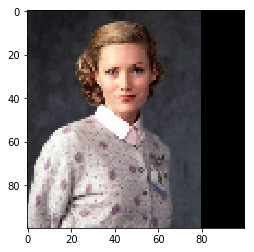

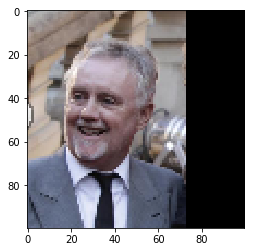

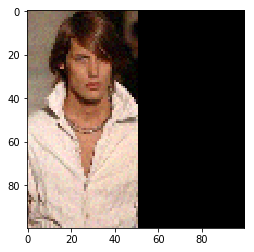

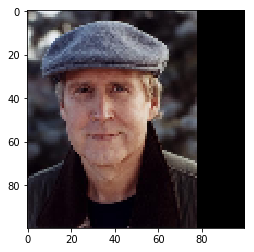

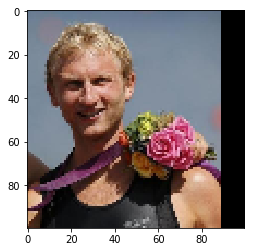

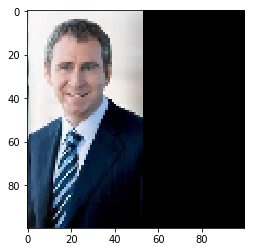

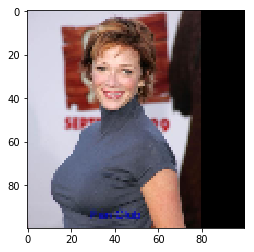

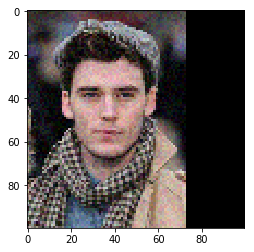

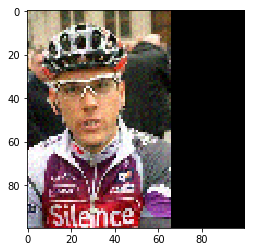

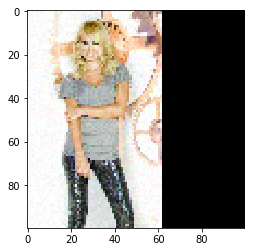

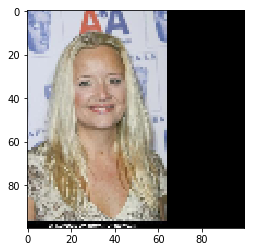

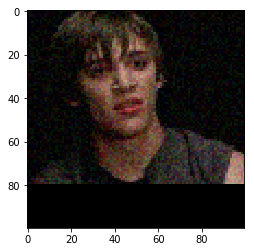

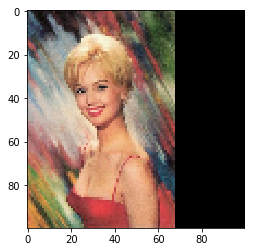

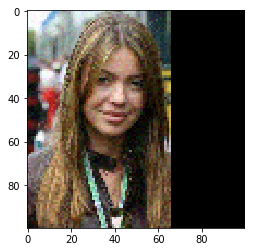

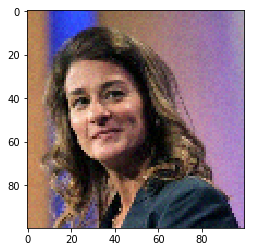

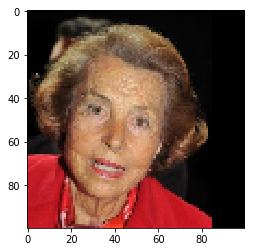

In [10]:
#Write a function to test the data generator
X, Y = dataGen(filelist, labels, batch_size=16)

for img in X:
    plt.imshow(img[...,::-1])
    plt.show()

## 3.3 - Visualising your training data

We recommend always visualising your training data after pre-processing, and after running through the data generator, because this is a phase where mistakes often happen that affect learning later on. 

One of the common mistakes when working with image data, is that OpenCV and NumPy have reversed X/Y axis orders. You might also scale the labels wrongly or make some other mistake. By visualising a few instances of the data, you can catch mistakes quickly.

**Exercise:** 

Write a function that takes an image and a face bounding box of the CelebA dataset, and visualises the annotated bounding box around the face.

- The format of the bounding box in this set is [x1, y1, width, height]

[hint](https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#rectangle)

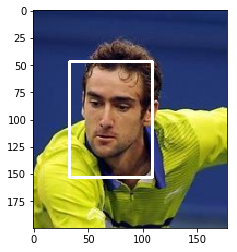

In [12]:
def visualise_label(image, label):
    '''
    function that takes an image and label,
    and visualises it.
    '''
    
    ###Start of coding segment###
    marked = cv2.rectangle(image, (label[0], label[1]), 
                           (label[0]+label[2], label[1]+label[3]),
                           (255,255,255), thickness=2)
    
    return marked

    ###End of coding segment


#Load first image and first label
im = cv2.imread('celeba_larger/data/100001.jpg')
labels = pd.read_csv('celeba_larger/labels/list_bbox_celeba.txt')

#then we'll run your pre-processing function and plot the result
resized_img, resized_label = pre_process(im, labels[1:2].values[0][1:],
                                        max_size=200)
marked = visualise_label(resized_img, resized_label)

#finally we'll plot the result
#alternatively you can plot inside the function, uncomment the following lines if you did
plt.imshow(marked[...,::-1])
plt.show()

### 3.4 - Fitting your Model

When fitting your model, there's interesting tricks we can do to make your life easier. 

In this section we'll show you how to:
- save models during training
- save progress statistics of training to a log file (loss, accuracy)
- automated early stopping

First let's get to work on saving your work between epochs. This is especially useful when you're working with models that take a long time to fit. They might start overfitting, in which case you'd want to go back to an earlier iteration. Or your computer might crash, power might fail, or any other nasty thing might happen.

These things in Keras are done by so-called 'callbacks'. A callback is basically a function that gets called at the end of each epoch. 

**Exercise:**

You don't need to complete the code below. Do take a look at how we implement the different callbacks and model fitting.

- Take note of the callback arguments and compare with [the Keras API here](https://keras.io/callbacks/)
- Note we set epochs higher than necessary, and let the early stopper do its work.
- We set a custom loss function like we did before. We want to predict 2d coordinates. The euclidean distance is a simple but effective measure of error.

Run the cell below after you've understood its contents. Let's see if you implemented the previous functions correctly and if we can get the model to learn something!

In [13]:
import os

if not os.path.exists('Models/'):
    os.mkdir('Models/')

from misc import convnet
from keras import callbacks
import keras.backend as K

#Define custom loss function
def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

#We define the filelist, labels, and split 1900/100
filelist = glob('celeba_larger/data/*.jpg')
labels = pd.read_csv('celeba_larger/labels/list_bbox_celeba.txt').values[:,1:,]

#Split the data 1900/100
files_train = filelist[:1900]
labels_train = labels[:1900]
files_val = filelist[1900:]
labels_val = labels[1900:]

#load and compile the model
model = convnet.build_model(input_shape=(100,100,3), classes=4, final_activation='sigmoid')
model.compile(loss=euclidean_distance,
              optimizer='adamax',
              metrics=['accuracy'])

#we define where to save models
filepath = 'Models/my_model.hdf5'
#we define the ModelCheckpoint callback
saver = callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                  verbose=1, save_best_only=True, 
                                  mode='min', period=1)
#we define the CSVLogger callback
logger = callbacks.CSVLogger('Models/trainingresults.log')
#we define the EalyStopping callback
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min',
                                        verbose=1, restore_best_weights=True)
#Important: put all callback functions in a list
callbacklist = [saver, logger, early_stopper]

#And specify the list in the fit() function:
model.fit_generator(dataGen(files_train, 
                            labels_train, 
                            batch_size=32, 
                            max_size=100),
                    epochs=100,
                    steps_per_epoch = len(filelist) // 32,
                    validation_data=(dataGen(files_val, labels_val,
                                             batch_size=10,
                                             max_size=100)),
                    validation_steps = 100 // 10,
                    callbacks = callbacklist)

Epoch 1/100
62/62 [==============================] - 13s 216ms/step - loss: 0.2222 - acc: 0.7823 - val_loss: 0.1661 - val_acc: 0.7700

Epoch 00001: val_loss improved from inf to 0.16605, saving model to Models/my_model.hdf5
Epoch 2/100
62/62 [==============================] - 13s 203ms/step - loss: 0.1634 - acc: 0.8286 - val_loss: 0.1600 - val_acc: 0.7700

Epoch 00002: val_loss improved from 0.16605 to 0.16003, saving model to Models/my_model.hdf5
Epoch 3/100
62/62 [==============================] - 13s 203ms/step - loss: 0.1526 - acc: 0.8407 - val_loss: 0.1588 - val_acc: 0.7100

Epoch 00003: val_loss improved from 0.16003 to 0.15878, saving model to Models/my_model.hdf5
Epoch 4/100
62/62 [==============================] - 12s 193ms/step - loss: 0.1434 - acc: 0.8407 - val_loss: 0.1589 - val_acc: 0.8400

Epoch 00004: val_loss did not improve from 0.15878
Epoch 5/100
62/62 [==============================] - 11s 184ms/step - loss: 0.1373 - acc: 0.8483 - val_loss: 0.1469 - val_acc: 0.8500


## 3.5 - Testing and Visualising Results

Now we come to the last segment of this notebook. Well done on getting this far!



Let's test your model, run the cell below!

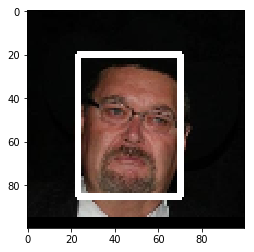

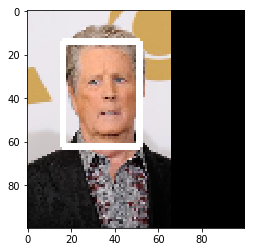

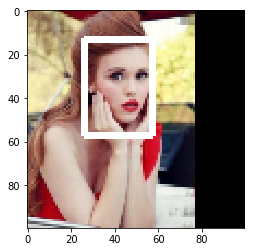

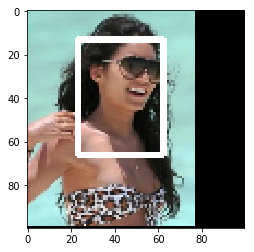

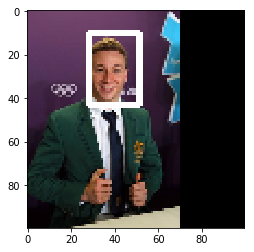

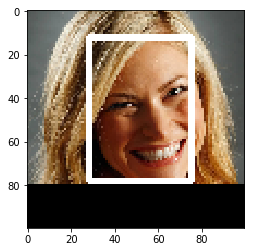

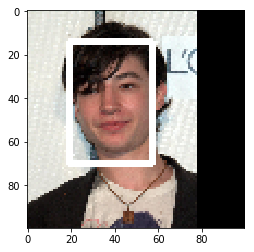

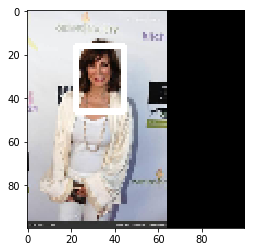

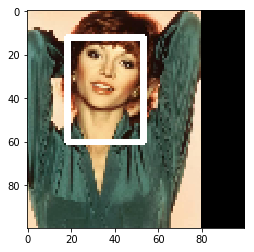

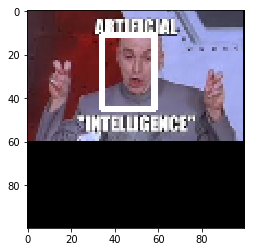

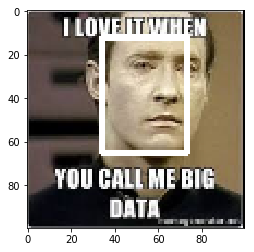

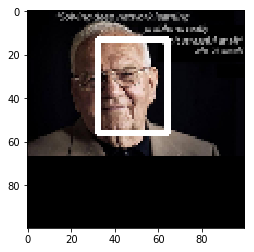

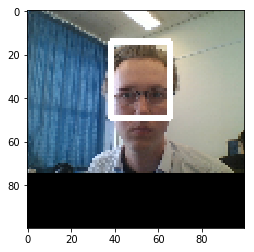

In [14]:
testdata = utils.prepare_celeba_testdata(max_size=100, c_channels=3)
    
Y = model.predict(np.asarray(testdata))

for prediction, img in zip(Y, testdata):
    img = np.uint8(img * 255)
    prediction = prediction * 100
    visualised = visualise_label(img, prediction)

    plt.imshow(visualised[...,::-1])
    plt.show()

**Are you satisfied?**

Likely the model does a few images quite well and a few less well. **Why do you think this is the case, would it help to get more training data?**

We'll give the answer away and say that indeed, more data is key in this problem (more in exercise 4 on detecting learning problems!). For example, we trained a slightly changed model with about 10 times *less* weights on a lot more data (200K images). Run the cell below to view how it performs.

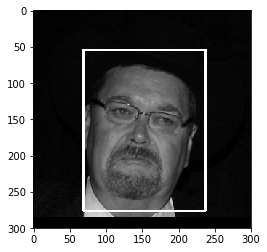

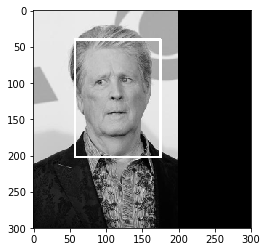

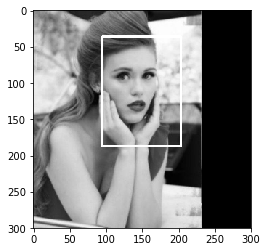

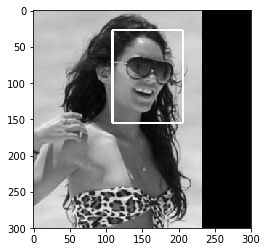

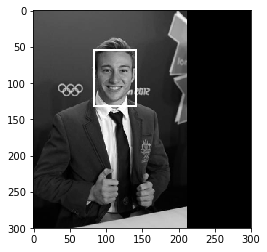

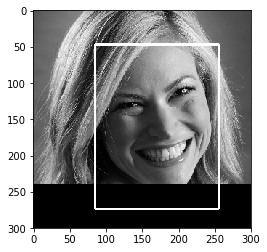

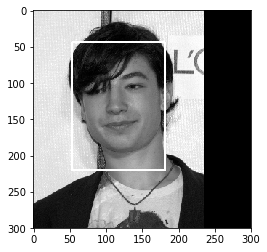

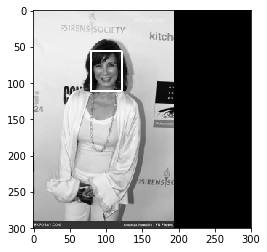

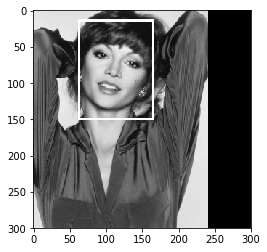

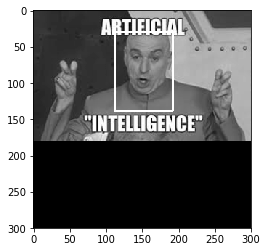

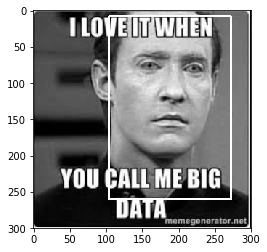

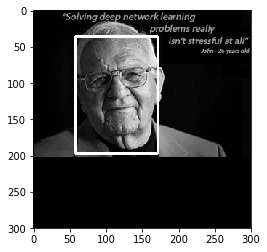

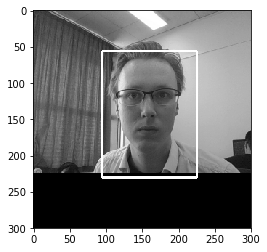

In [15]:
from keras.models import load_model

keras.losses.euc_dist_keras = euclidean_distance

model = load_model('misc/bb_model.hdf5')

testdata = utils.prepare_celeba_testdata(max_size=300, c_channels=1)
    
Y = model.predict(np.asarray(testdata))

for prediction, img in zip(Y, testdata):
    img = np.uint8(img * 255)
    prediction = prediction * 300
    visualised = cv2.rectangle(img, (prediction[0], prediction[1]), 
                               (prediction[2], prediction[3]), (255,255,255),
                               thickness=2)

    plt.imshow(visualised[:,:,-1], cmap='gray')
    plt.show()